In [34]:
import pm4py
print(pm4py.__version__)

1.1.18


In [32]:
# importing a XES log as an 'EventLog' object
from pm4py.objects.log.importer.xes import factory as xes_importer
log = xes_importer.apply("C:\\running-example.xes")

In [3]:
print(log)

[{'attributes': {'concept:name': '3', 'creator': 'Fluxicon Nitro'}, 'events': [{'concept:name': 'register request', 'org:resource': 'Pete', 'time:timestamp': datetime.datetime(2010, 12, 30, 14, 32, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))), 'Activity': 'register request', 'Resource': 'Pete', 'Costs': '50'}, '..', {'concept:name': 'pay compensation', 'org:resource': 'Ellen', 'time:timestamp': datetime.datetime(2011, 1, 15, 10, 45, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))), 'Activity': 'pay compensation', 'Resource': 'Ellen', 'Costs': '200'}]}, '....', {'attributes': {'concept:name': '4', 'creator': 'Fluxicon Nitro'}, 'events': [{'concept:name': 'register request', 'org:resource': 'Pete', 'time:timestamp': datetime.datetime(2011, 1, 6, 15, 2, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))), 'Activity': 'register request', 'Resource': 'Pete', 'Costs': '50'}, '..', {'concept:name': 'reject request', 'org:resource': 'Ellen', 'time:timestamp': datetime.dateti

In [33]:
# importing a CSV as a Pandas dataframe
from pm4py.objects.log.adapters.pandas import csv_import_adapter as csv_importer
df = csv_importer.import_dataframe_from_path("C:\\running-example.csv")

In [5]:
print(df)

    Unnamed: 0            Activity  Costs Resource  case:concept:name  \
0            0    register request     50     Pete                  3   
1            1    examine casually    400     Mike                  3   
2            2        check ticket    100    Ellen                  3   
3            3              decide    200     Sara                  3   
4            4  reinitiate request    200     Sara                  3   
5            5  examine thoroughly    400     Sean                  3   
6            6        check ticket    100     Pete                  3   
7            7              decide    200     Sara                  3   
8            8    pay compensation    200    Ellen                  3   
9            9    register request     50     Mike                  2   
10          10        check ticket    100     Mike                  2   
11          11    examine casually    400     Sean                  2   
12          12              decide    200     Sara 

In [6]:
# pre-processing log objects: keeping only cases/events of interest
from pm4py.algo.filtering.log.end_activities import end_activities_filter
filtered_log = end_activities_filter.apply(log, ["pay compensation"])
print(len(log), len(filtered_log))

6 3


In [7]:
# pre-processing dataframe objects: keeping only cases/events of interest
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter as pd_end_activities_filter
filtered_df = pd_end_activities_filter.apply(df, ["pay compensation"])
print(len(df), len(filtered_df), len(df.groupby("case:concept:name")), len(filtered_df.groupby("case:concept:name")))

42 19 6 3


In [8]:
# converting one format to the other
from pm4py.objects.conversion.log import factory as log_conv_factory
conv_log = log_conv_factory.apply(df)
print(len(conv_log))

6


In [9]:
# apply a discovery algorithm (IMDFb) to the EventLog object
from pm4py.algo.discovery.inductive import factory as inductive_miner
# discovers an accepting Petri net
net, im, fm = inductive_miner.apply(log)

In [10]:
# the same exact discovery technique can be applied directly to Pandas dataframes! :)
from pm4py.algo.discovery.inductive import factory as inductive_miner
# discovers an accepting Petri net
net, im, fm = inductive_miner.apply(df)

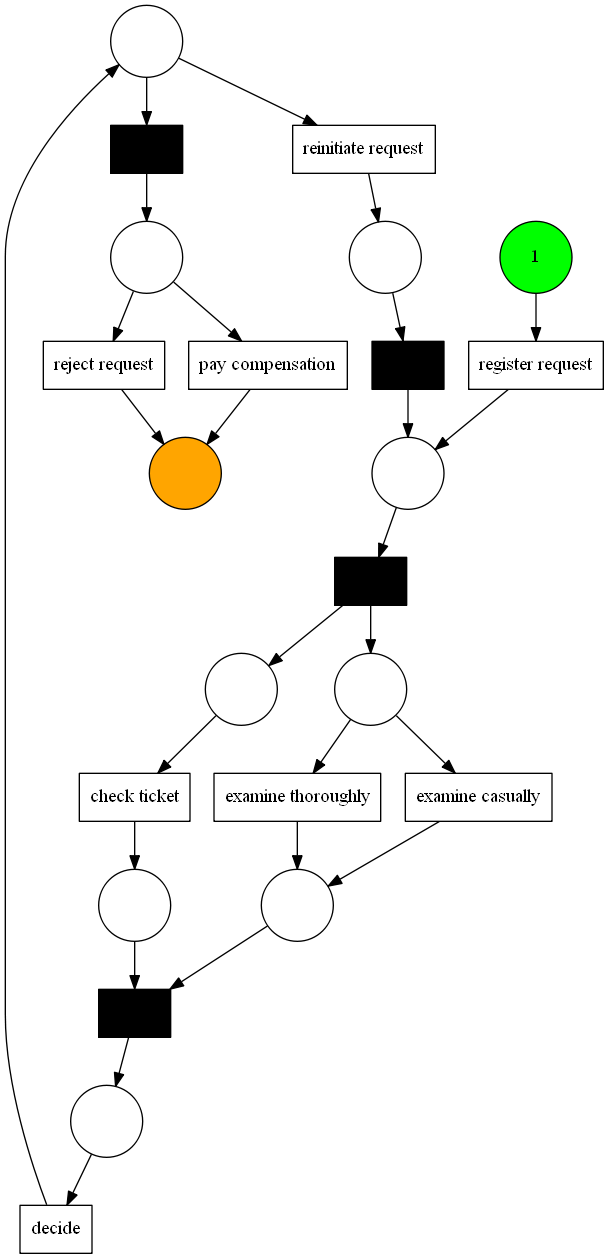

In [11]:
# perform a visualization of the Petri net that is discovered
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)

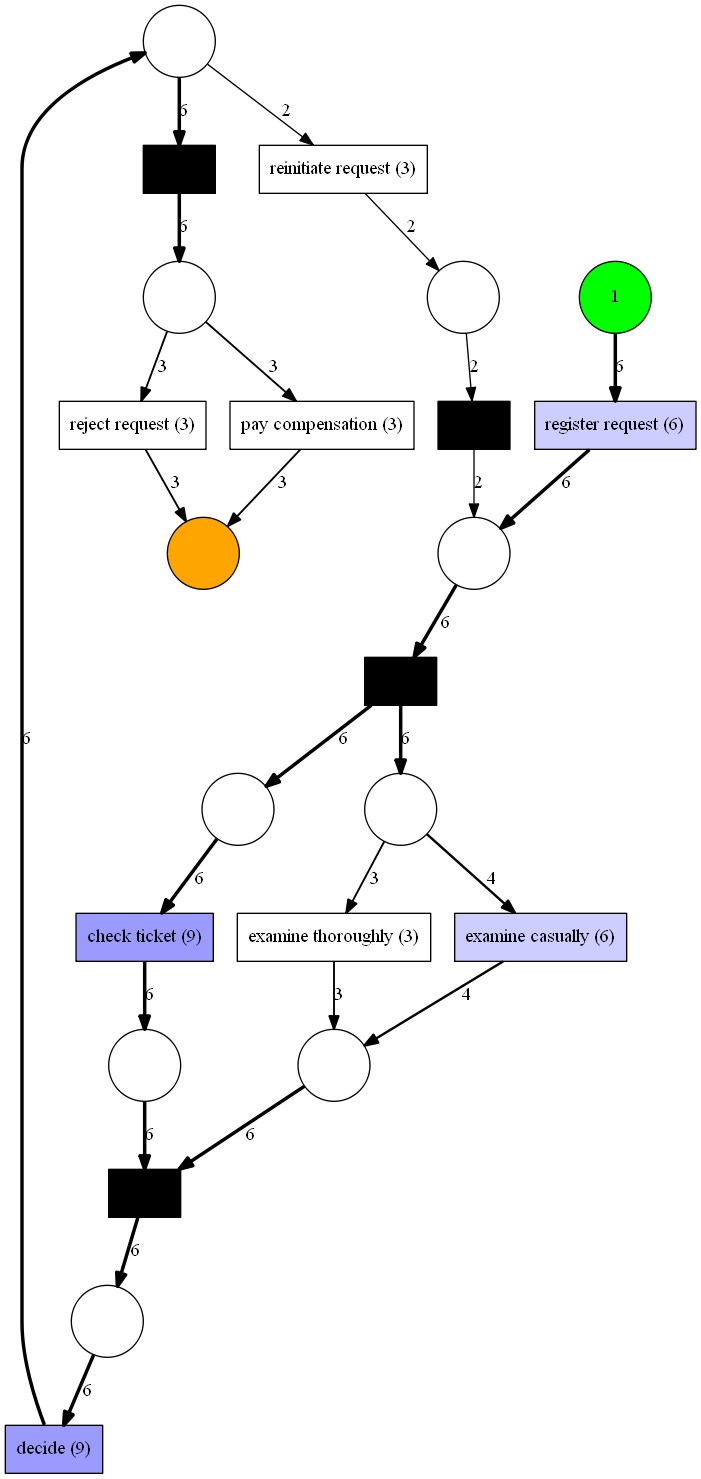

In [12]:
# perform a visualization of the Petri net that is discovered
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm, variant="frequency", log=log)
pn_vis_factory.view(gviz)

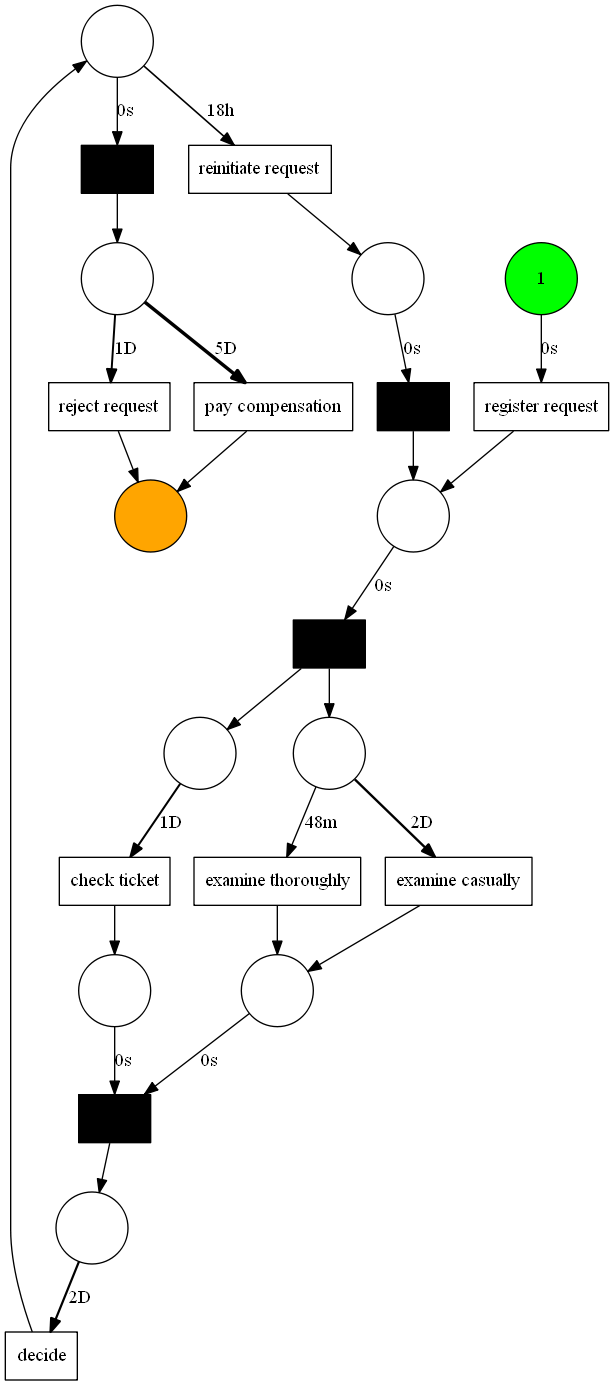

In [13]:
# perform a visualization of the Petri net that is discovered (PERFORMANCE!)
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm, variant="performance", log=log)
pn_vis_factory.view(gviz)

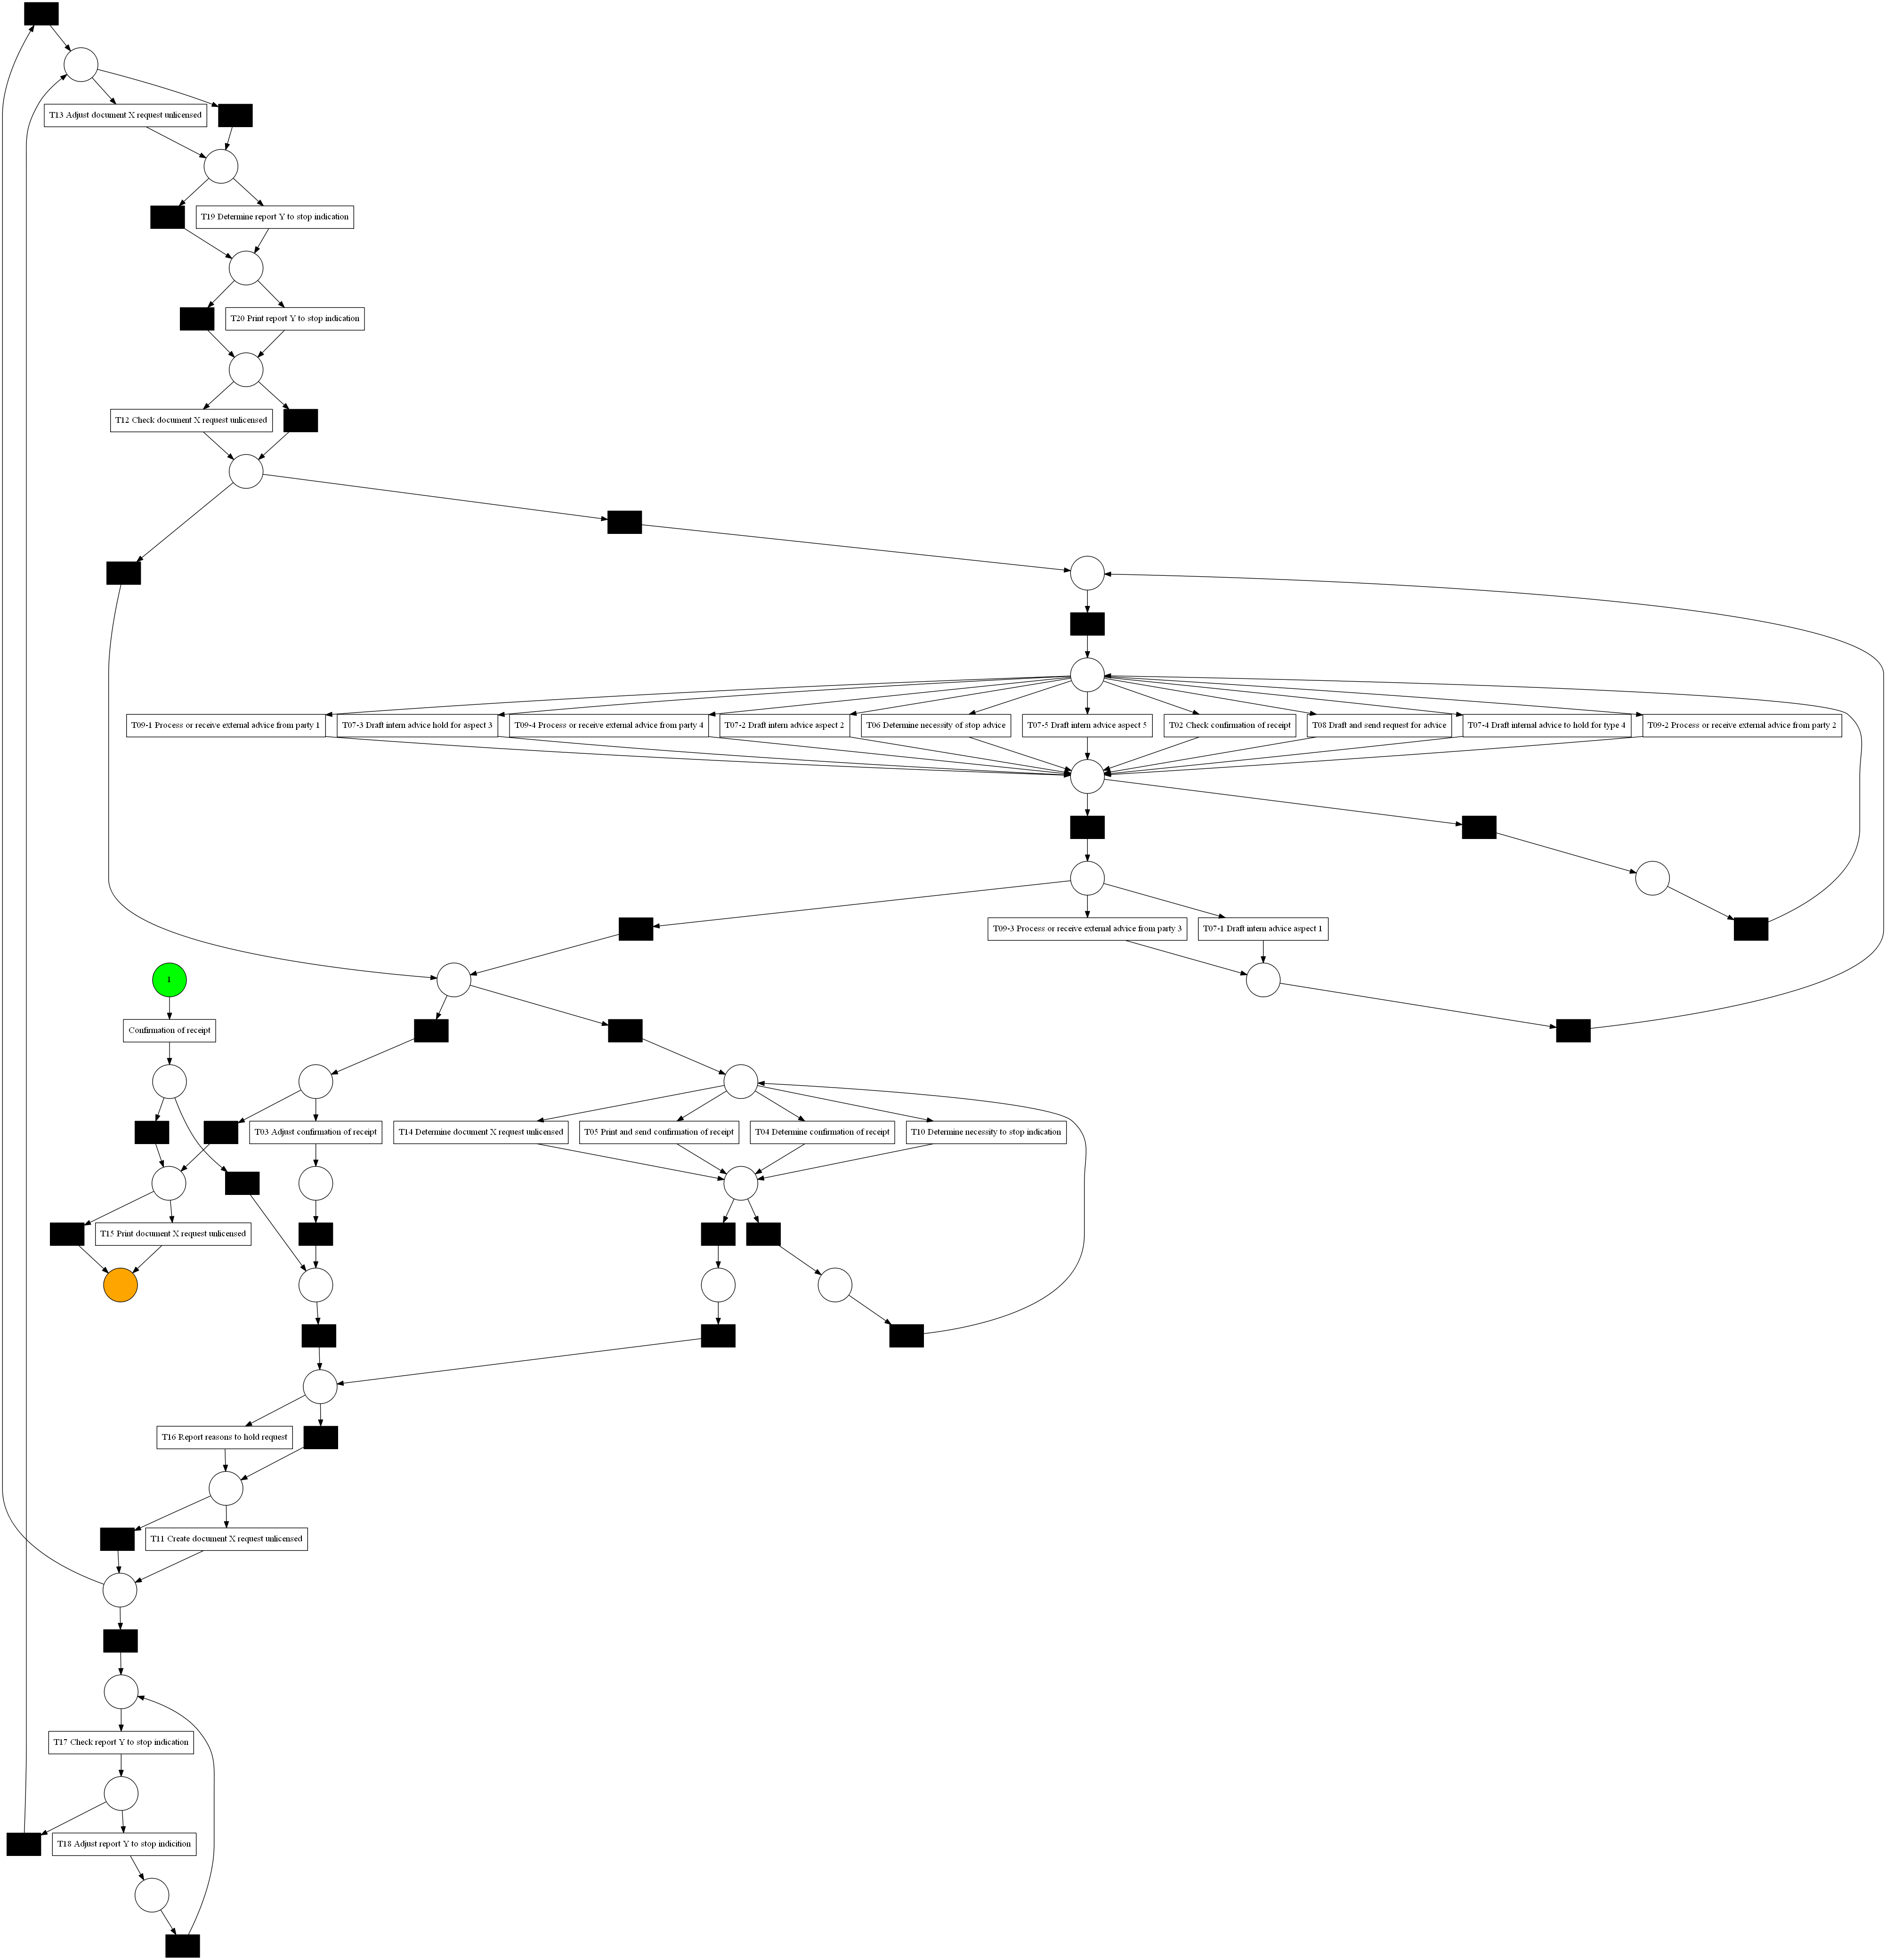

In [14]:
# try to discover a model from more complex log
from pm4py.objects.log.importer.xes import factory as xes_importer
log = xes_importer.apply("C:\\receipt.xes")
from pm4py.algo.discovery.inductive import factory as inductive_miner
# discover a model with perfect fitness from such a log
net, im, fm = inductive_miner.apply(log)
# get a visualization
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)

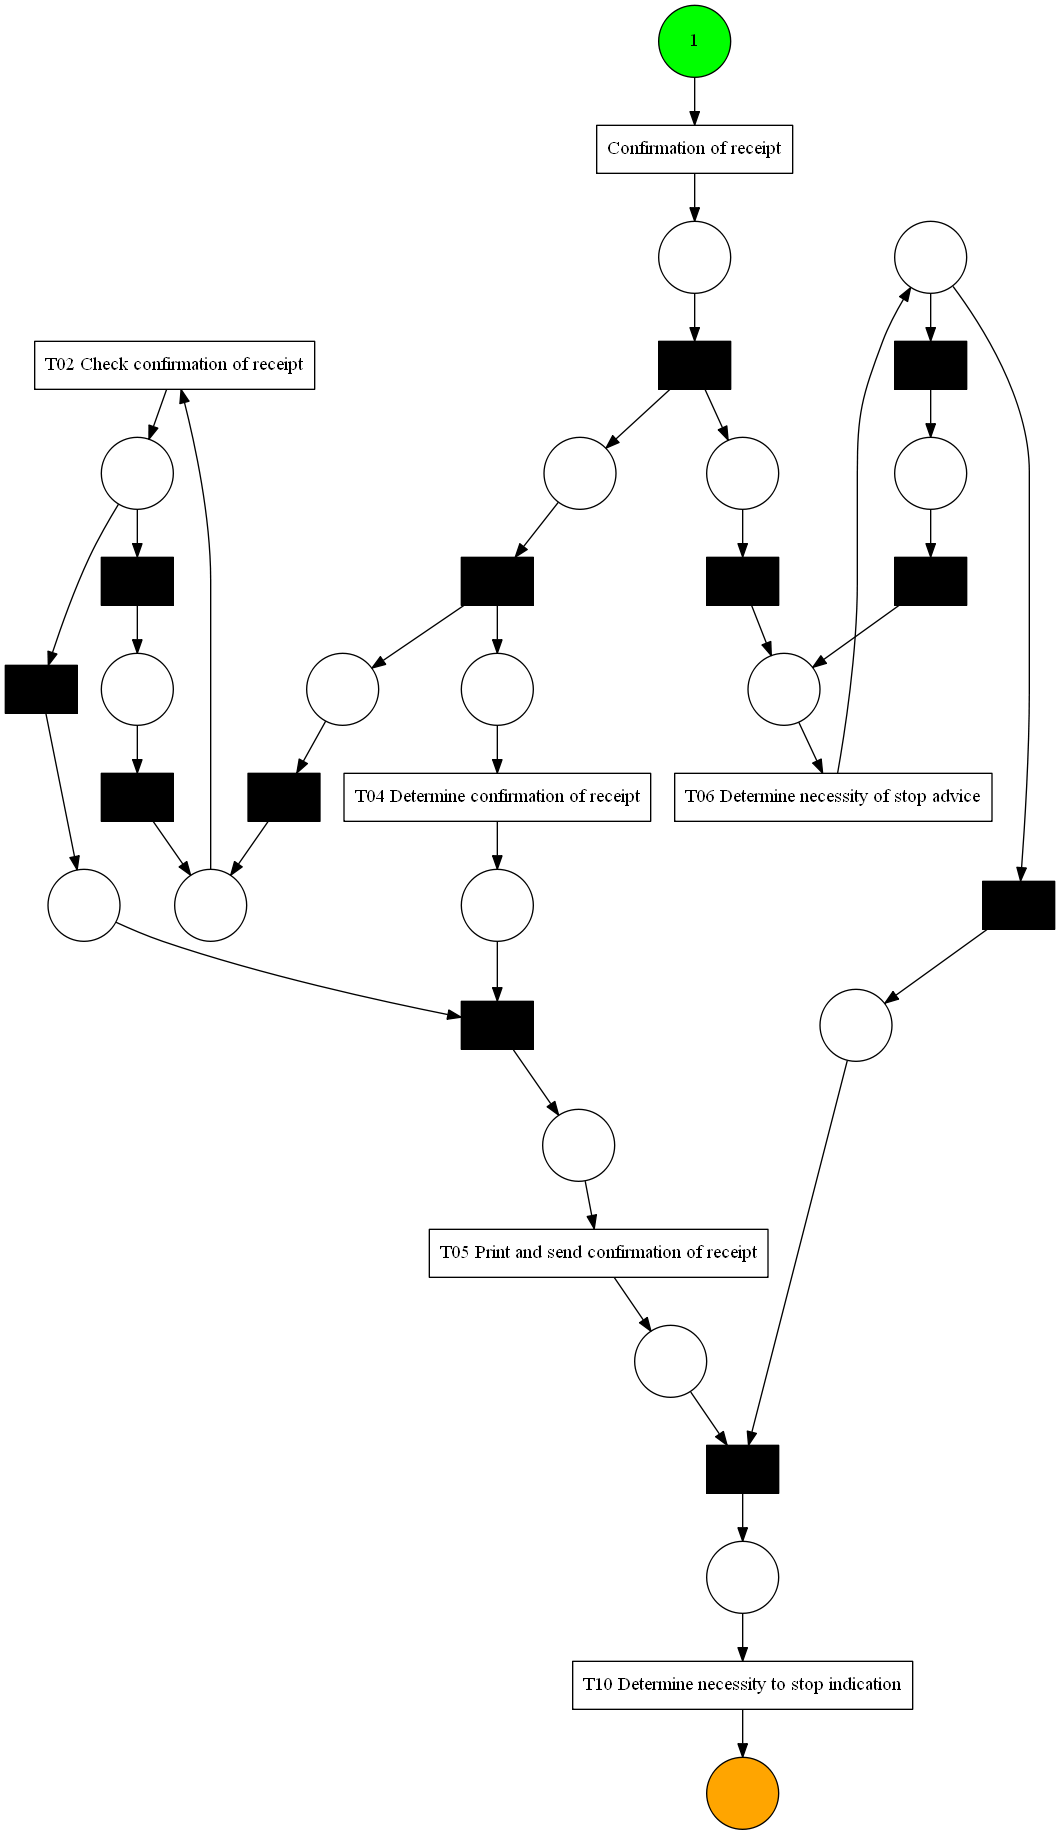

In [15]:
# apply automatic filtering!
# get a log with only mainstream behavior
from copy import deepcopy
from pm4py.algo.filtering.log.auto_filter import auto_filter
filtered_log = auto_filter.apply_auto_filter(deepcopy(log))
# discover a model, on the filtered log, that is simpler
from pm4py.algo.discovery.inductive import factory as inductive_miner
net, im, fm = inductive_miner.apply(filtered_log)
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)

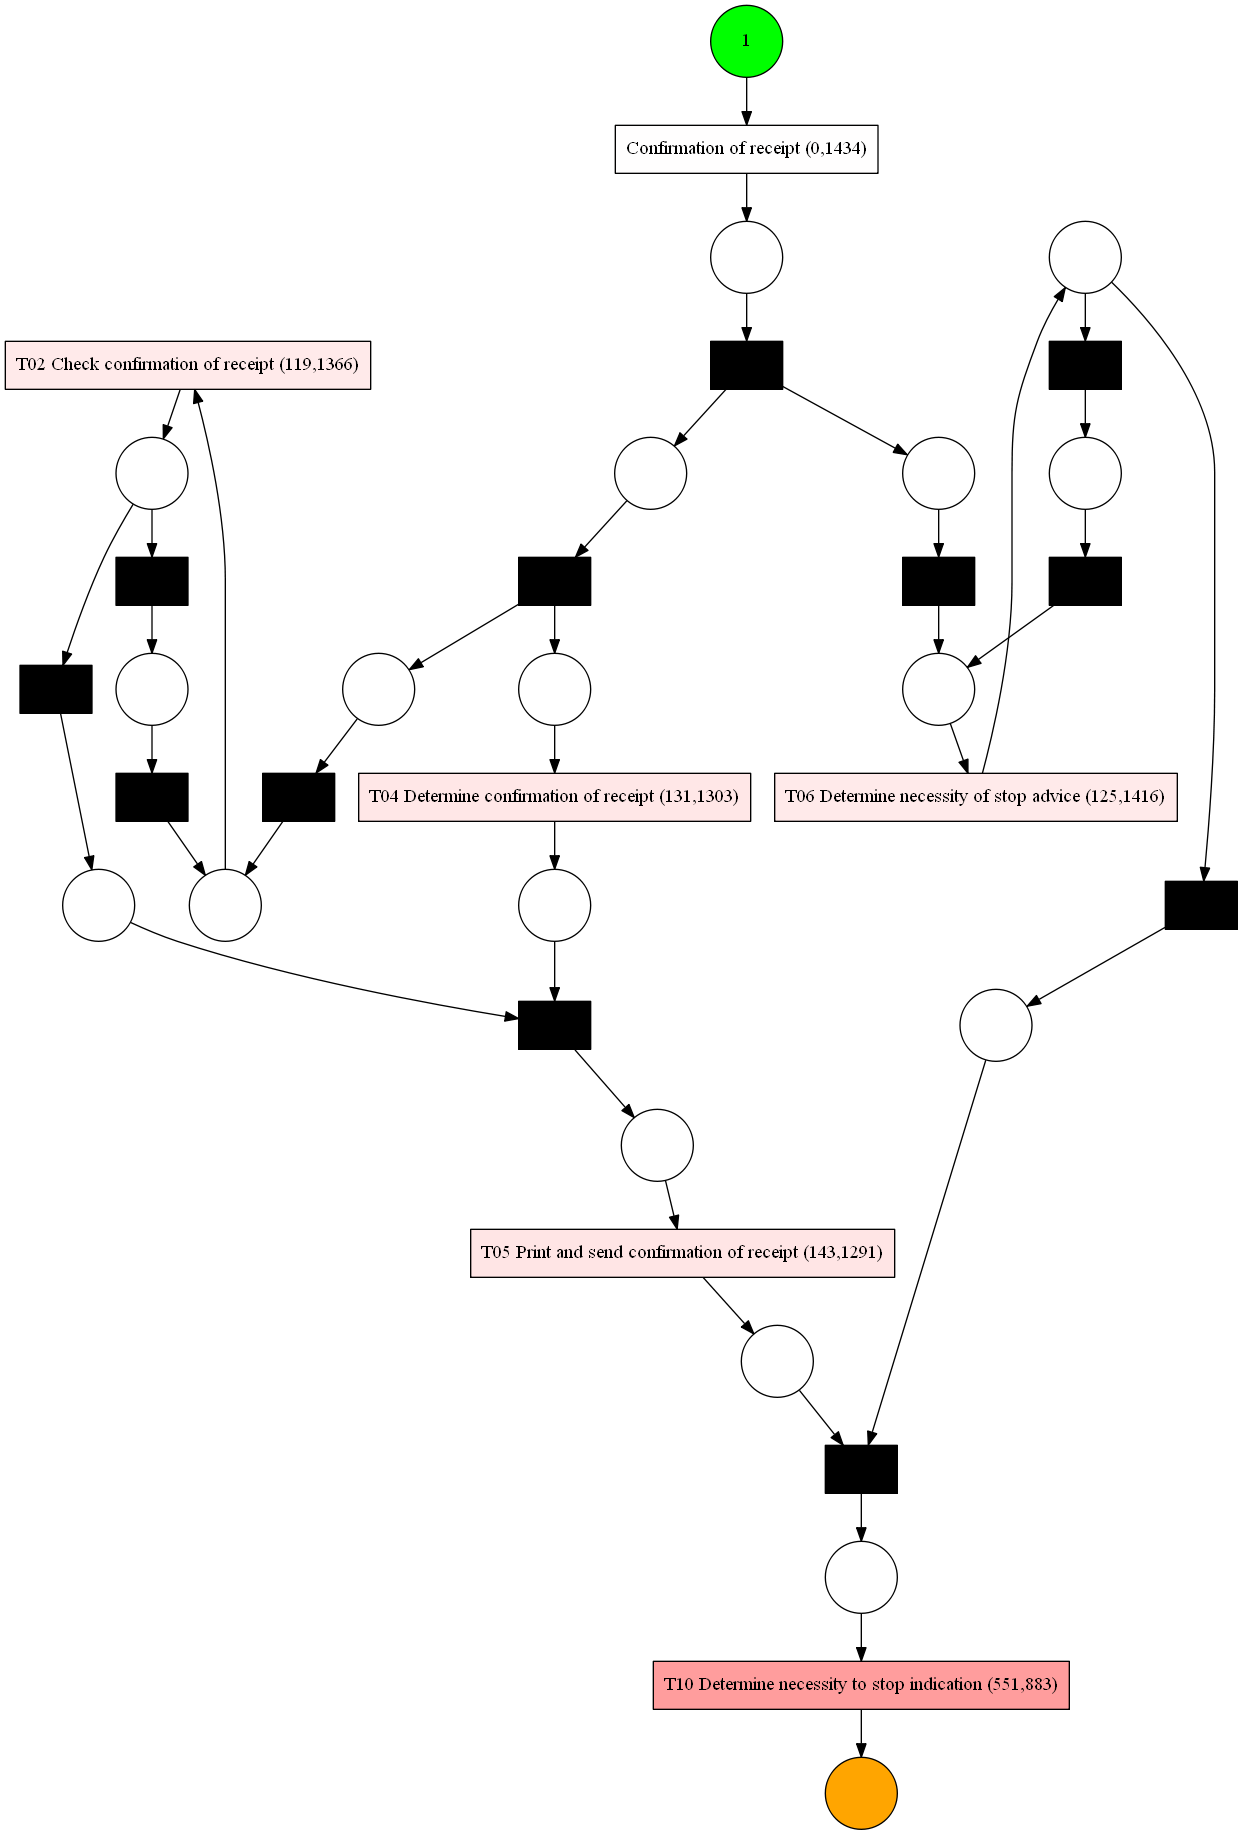

In [16]:
# this model is not perfectly fit according to the original log!
# see where deviations are
from pm4py.algo.conformance.alignments import factory as align_factory
alignments = align_factory.apply(log, net, im, fm, parameters={"ret_tuple_as_trans_desc": True})
from pm4py.visualization.petrinet.util import alignments_decoration
decorations = alignments_decoration.get_alignments_decoration(net, im, fm, log=log)
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm, aggregated_statistics=decorations, variant="alignments")
pn_vis_factory.view(gviz)

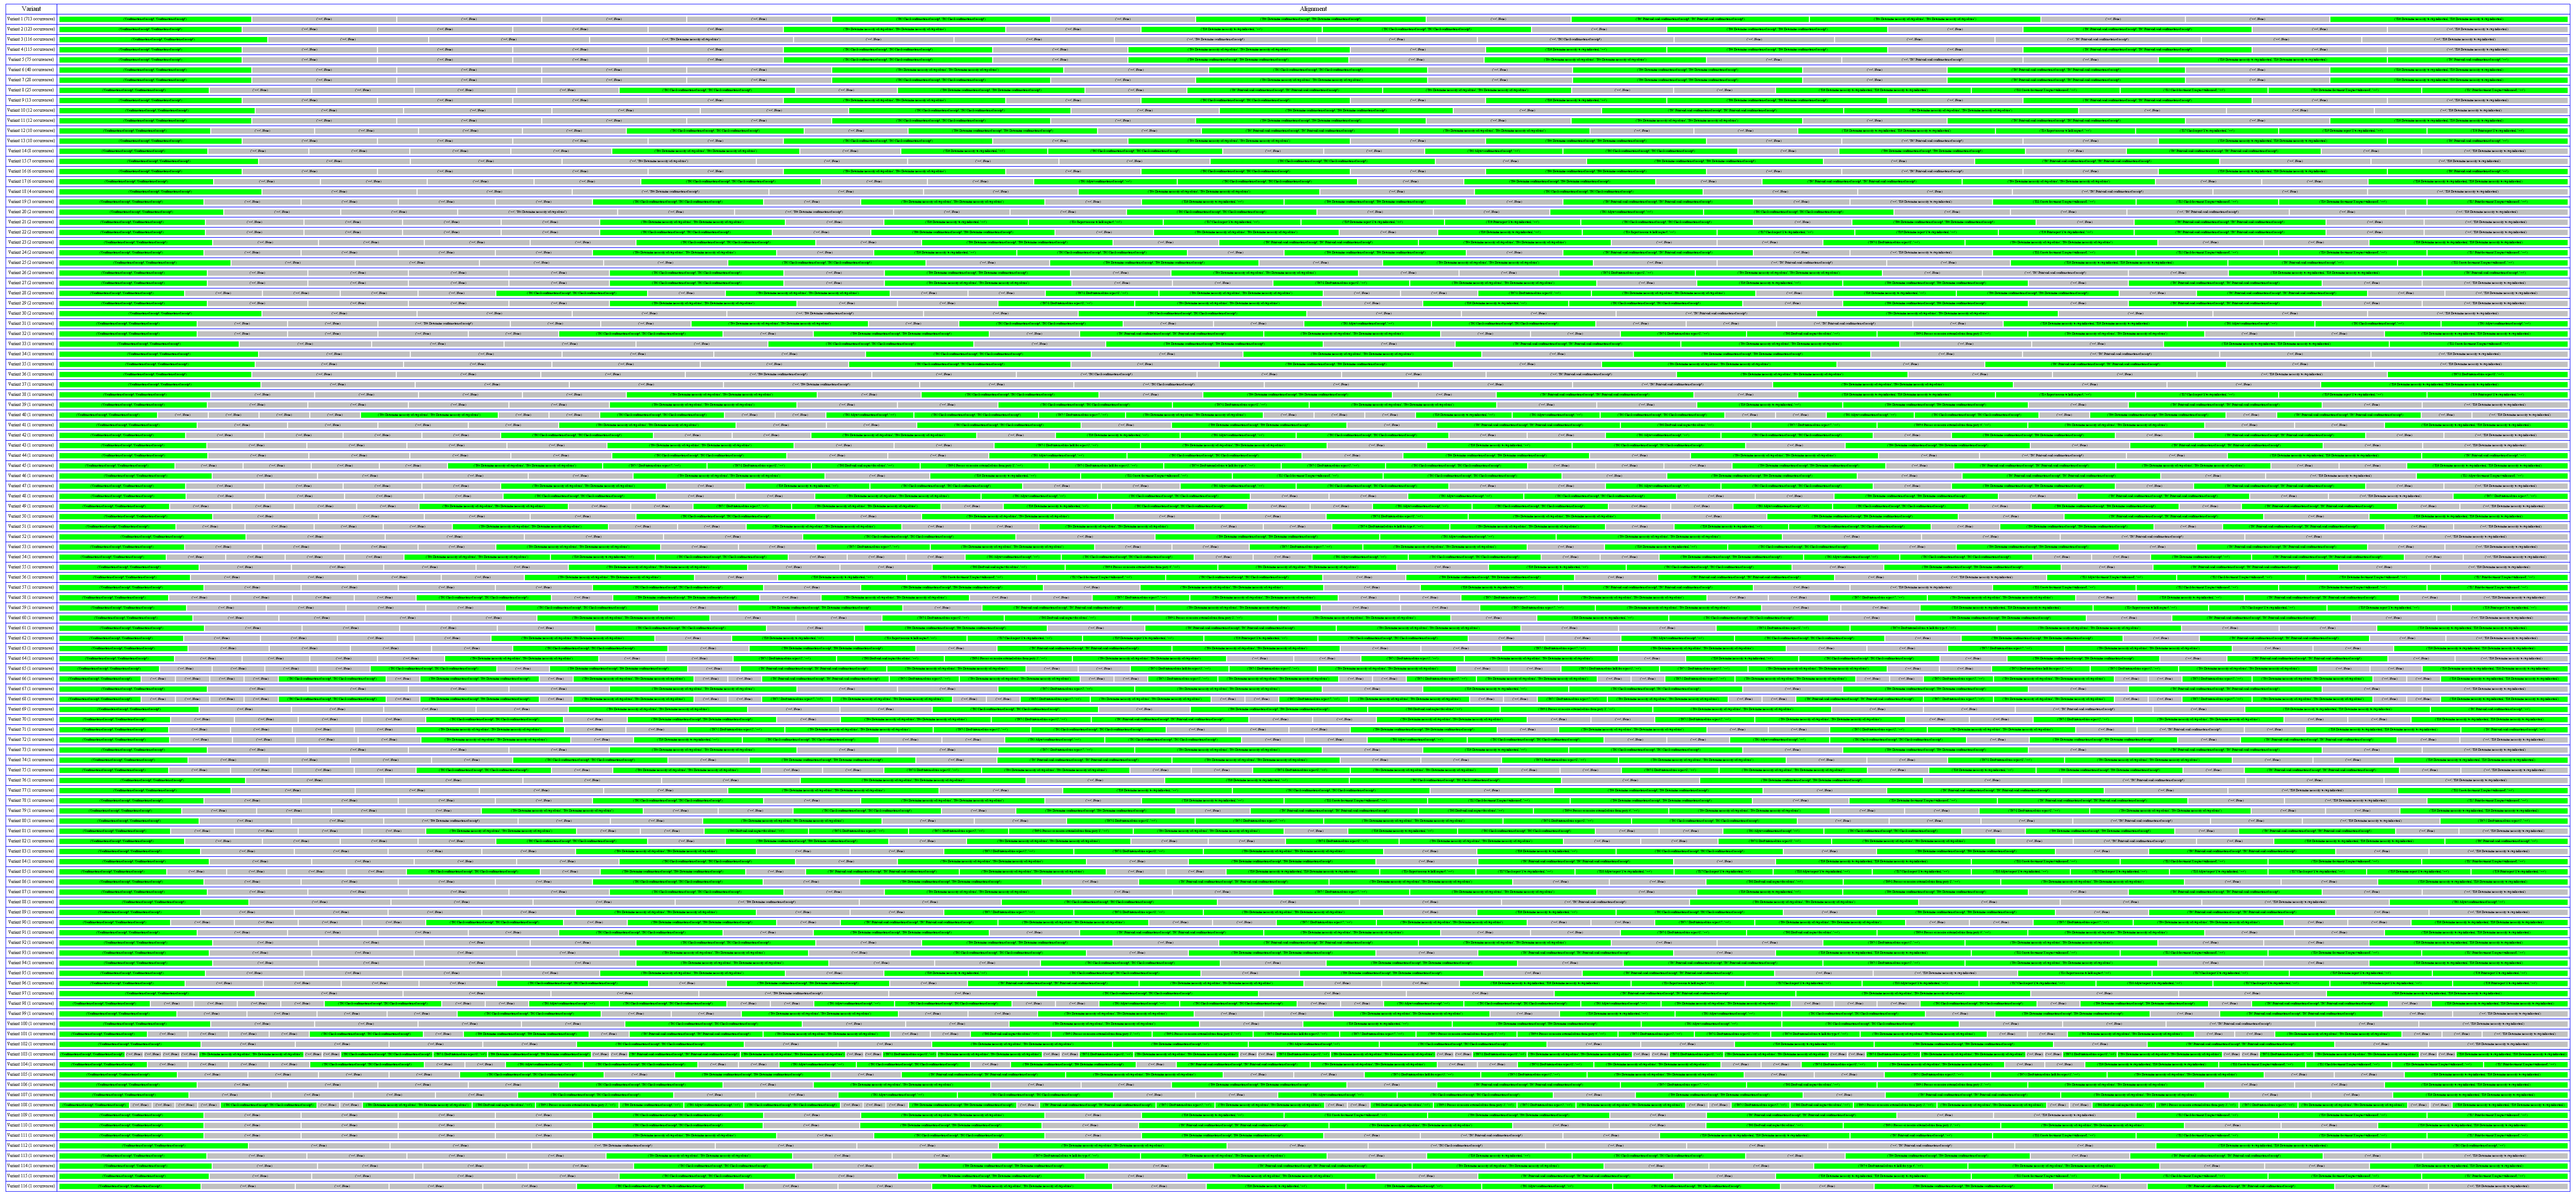

In [17]:
# get also the alignments table! :)
from pm4py.visualization.align_table import factory as align_table_factory
gviz = align_table_factory.apply(log, alignments)
align_table_factory.view(gviz)

In [18]:
# we have also token-based replay!
# with diagnostics
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay
parameters_tbr = {"disable_variants": True, "enable_pltr_fitness": True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net,
                                                                                              im,
                                                                                              fm,
                                                                                              parameters=parameters_tbr)

In [19]:
# THROUGHPUT ANALYSIS ON UNFIT EXECUTION OF TRANSITIONS
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(log, trans_fitness)
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

T04 Determine confirmation of receipt {'n_fit': 1299, 'n_underfed': 4, 'fit_median_time': 10485.481, 'underfed_median_time': 617708.762, 'relative_throughput': 58.91086560549773}
T05 Print and send confirmation of receipt {'n_fit': 1299, 'n_underfed': 1, 'fit_median_time': 10406.875, 'underfed_median_time': 375.258, 'relative_throughput': 0.03605866314335475}
T10 Determine necessity to stop indication {'n_fit': 871, 'n_underfed': 412, 'fit_median_time': 681.958, 'underfed_median_time': 159874.352, 'relative_throughput': 234.43430827118388}


In [20]:
# measure fitness (through token-based replay)
from pm4py.evaluation.replay_fitness import factory as rp_fitness_factory
fitness = rp_fitness_factory.apply(log, net, im, fm)
print(fitness)

{'perc_fit_traces': 60.599721059972104, 'average_trace_fitness': 0.9127336372367774, 'log_fitness': 0.9237211781210803}


In [21]:
# measure precision (through a variant of the ETConformance algorithm)
from pm4py.evaluation.precision import factory as precision_factory
precision = precision_factory.apply(log, net, im, fm)
print(precision)

0.6258530183727034


In [22]:
# measure generalization (through Bujis technique)
from pm4py.evaluation.generalization import factory as generalization_factory
generalization = generalization_factory.apply(log, net, im, fm)
print(generalization)

0.9521317225735704


In [23]:
# measure simplicity (through arc degree)
from pm4py.evaluation.simplicity import factory as simplicity_factory
simplicity = simplicity_factory.apply(net)
print(simplicity)

0.4864864864864865


In [24]:
# export the Petri net
from pm4py.objects.petri.exporter import factory as petri_exporter
petri_exporter.apply(net, im, "net.pnml", final_marking=fm)

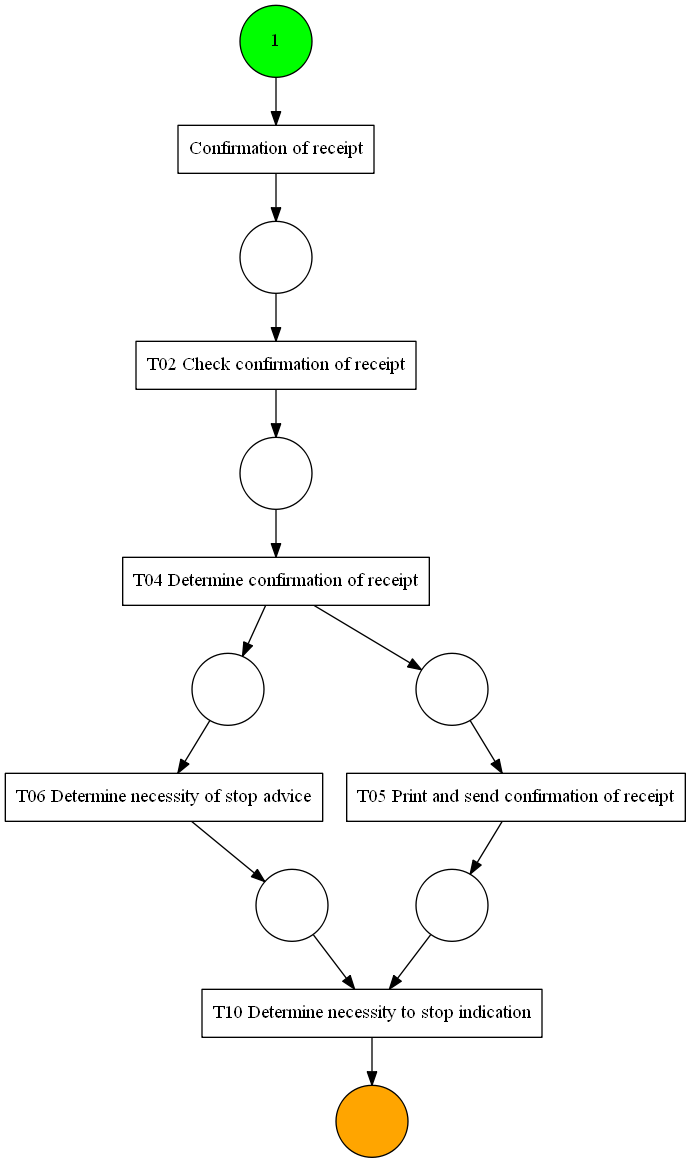

In [25]:
# SIMPLE MINER: discover a workflow net without invisible transitions
from pm4py.algo.discovery.simple.model.log import factory as simple_discovery_factory
net, im, fm = simple_discovery_factory.apply(filtered_log, classic_output=True)
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, im, fm)
pn_vis_factory.view(gviz)

In [26]:
# gets a map of the stochastic transitions that best approximate the replayed times passed
# between the activities
from pm4py.objects.stochastic_petri import map as stochastic_map
smap = stochastic_map.get_map_from_log_and_net(log, net, im, fm)
print(smap)

C:\Users\berti\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1720: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\berti\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\berti\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


{Confirmation of receipt: IMMEDIATE, T02 Check confirmation of receipt: EXPONENTIAL 8.908482071014465e-06, T04 Determine confirmation of receipt: EXPONENTIAL 1.94061409054316e-05, T06 Determine necessity of stop advice: EXPONENTIAL 3.5293993383690103e-06, T10 Determine necessity to stop indication: EXPONENTIAL 2.2474851458230767e-05, T05 Print and send confirmation of receipt: EXPONENTIAL 1.4102955460371511e-05}


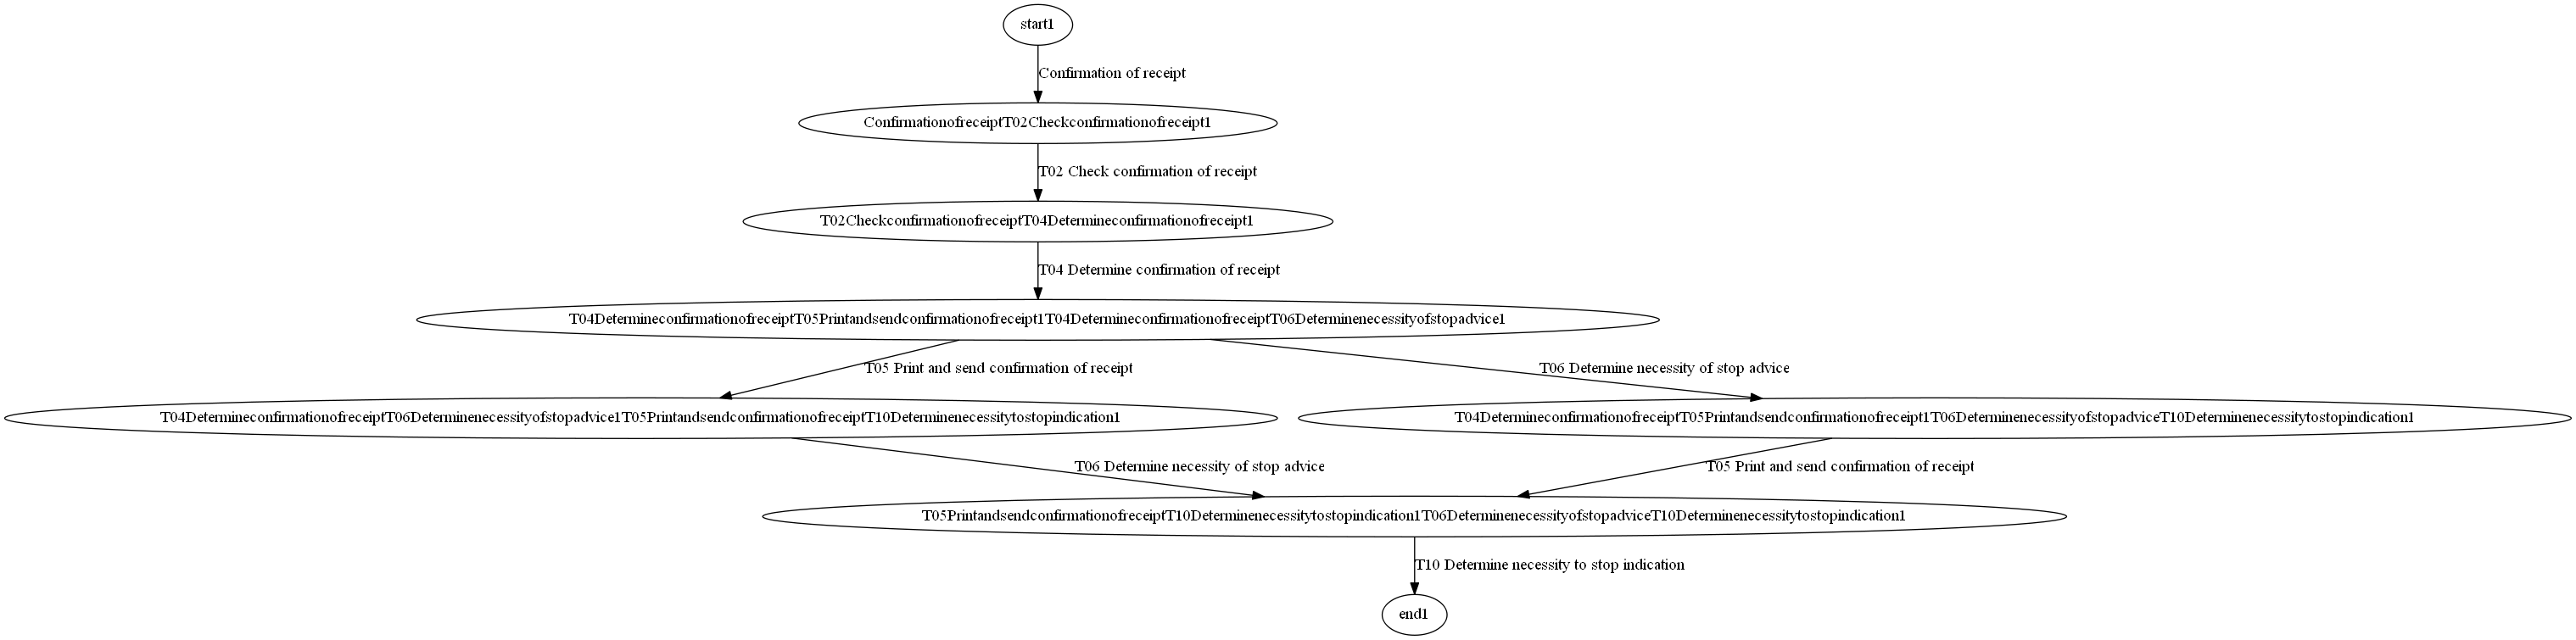

In [27]:
# construct the reachability graph
from pm4py.objects.petri.reachability_graph import construct_reachability_graph
reachab_graph = construct_reachability_graph(net, im)
from pm4py.visualization.transition_system import factory as ts_vis_factory
gviz = ts_vis_factory.apply(reachab_graph)
ts_vis_factory.view(gviz)

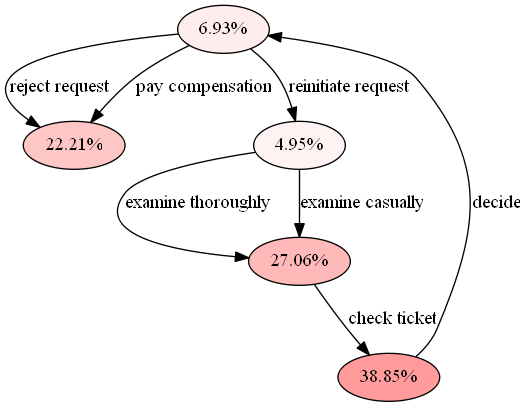

In [40]:
# perform transient analysis with Continuous Time Markov Chains (from the initial state, after a delay of 86400 s)
from pm4py.objects.stochastic_petri import ctmc
tang_reach_graph, probabilities, color_dictionary = ctmc.transient_analysis_from_log(log, 6*86400)
viz = ts_vis_factory.apply(tang_reach_graph, parameters={"format": "png",
                                                             "force_names": probabilities,
                                                             "fillcolors": color_dictionary})
ts_vis_factory.view(viz)